## Neural Network Operations: Convolution and Pooling

In our discussions throughout the rest of the course, we will often refer to convolution and pooling operations and use these as the basic building blocks of a substantial portion of our work. In this notebook, you will write your own basic convolution operation and apply it to an image. You'll then compare your implementation to the convolution implementation in MyGrad. Finally, you will implement your own max-pooling operation and compare that implementation against the MyGrad implementation.

These operations all act on *windows* of an image. `mygrad.sliding_window_view` is very useful for this!

<IPython.core.display.Javascript object>


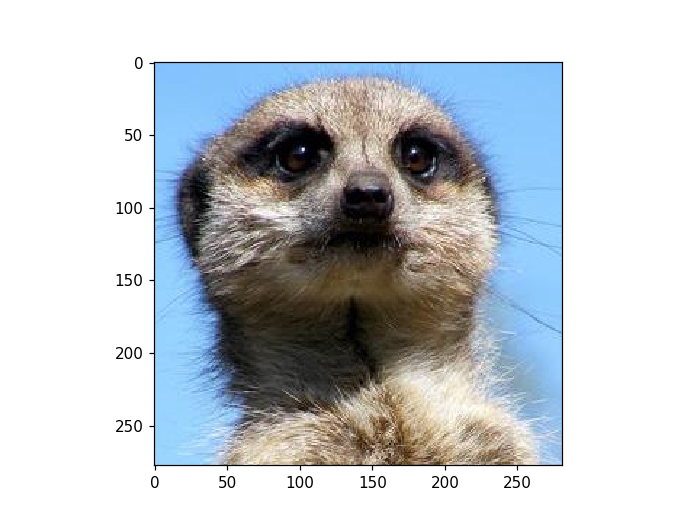

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import mygrad
import mygrad as mg
%matplotlib notebook
img = mpimg.imread('./pics/meerkat.png')

fig, ax = plt.subplots()
ax.imshow(img);

Let's visualize "windowing" this image using shape-(24, 24) windows, strided along H and W with a step size of 24. (Try changing these parameters). 

In [3]:
from mygrad import sliding_window_view
x  = img.transpose(2, 0, 1)  # (H, W, C) --> (C, H, W)  (we window over the trailing dimensions)
windowed_img = sliding_window_view(x, window_shape=(24, 24), step=24)
windowed_img.shape

(11, 11, 3, 24, 24)

According to the shape of `windowed_img`, we placed each shape-(24, 24) window at 11x11 locations. Let's visualize this, plotting each of the 11x11 window placements. 

<IPython.core.display.Javascript object>


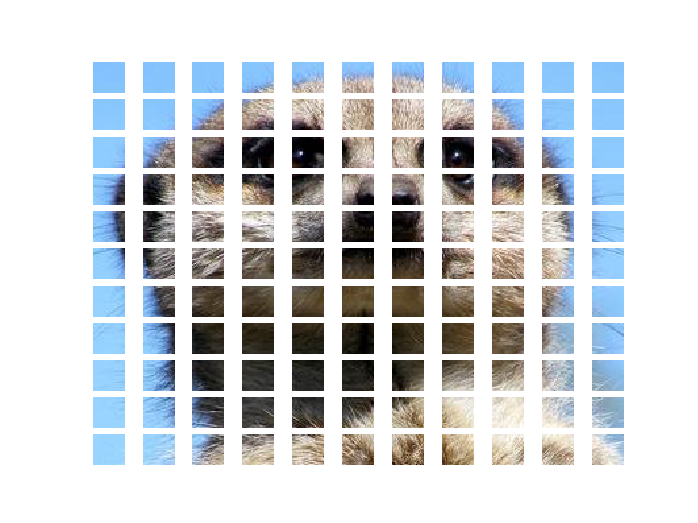

In [4]:
fig,ax = plt.subplots(nrows=windowed_img.shape[0], ncols=windowed_img.shape[1])
for i,j in np.ndindex(windowed_img.shape[:2]):
    ax[i,j].imshow(windowed_img[i,j].transpose(1, 2, 0))  # (C, Hw, Ww) -> (Hw, Ww, C)
    ax[i,j].axis('off')

Try using different window-shape and stride combinations. Like window-(48, 48) with stride-(12,)

## Writing Your Own Convolution Function

The first thing we'll need to do in order to perform convolution is figure out what our output shape is going to be, given our input shape and our filter shape. Recall that we'll be sliding our convolutional filter across the image at every valid location with a given stride. Then our output shape will be

\begin{equation}
shape_\text{out} = \frac{shape_\text{in} - shape_\text{filter}}{stride} + 1
\end{equation}

It is important to verify that we get valid dimensions here: we can't have fractional or negative sizes. Let's define a function now that will compute the output shape:

In [5]:
def get_outshape(x_shape, w_shape, stride):
    ''' Compute the shape of the output tensor given an input shape, convolutional
    filter shape, and stride.
    
    Parameters
    ----------
    x_shape : Tuple[int, int]
        The shape of the input tensor.
        
    w_shape : Tuple[int, int]
        The shape of the convolutional filter.
        
    stride : Tuple[int, int]
        The stride at which to apply the convolutional filter to the input.
        
    Returns
    -------
    numpy.ndarray[int], shape=(2,)
        The shape of the output tensor resulting from convolving a tensor of shape `x_shape`
        with a tensor of shape `w_shape`.
    '''
    x_shape = np.array(x_shape)
    w_shape = np.array(w_shape)
    stride = np.array(stride)

    out_shape = (x_shape - w_shape) / stride + 1

    if not all(i.is_integer() and i > 0 for i in out_shape):
        msg = "Stride and kernel dimensions are incompatible: \n"
        msg += "Input dimensions: {}\n".format(tuple(x_shape))
        msg += "Stride dimensions: {}\n".format(tuple(stride))
        msg += "Kernel dimensions: {}\n".format(tuple(w_shape))
        raise ValueError(msg)
    return out_shape.astype(np.int32)

We should perform a sanity check to verify that our function is working correctly. We'll try a few test cases.

In [6]:
assert tuple(get_outshape((10, 10), (3, 3), (1, 1))) == (8, 8)
assert tuple(get_outshape((11, 11), (3, 3), (2, 2))) == (5, 5)
assert tuple(get_outshape((10, 10), (5, 5), (1, 1))) == (6, 6)

Now we can define a function that will perform our convolution. We'll expect an image of shape $(C, H, W)$ ($C$ color-channels, $H$ pixels along the vertical, $W$ pixels along the horizontal) and a convolutional filter of shape $(C, H_f, W_f)$, along with a spatial stride of $(s_y, s_x)$. We'll compute our output shape, then construct an output array of the correct shape using our function above. Once we have our output array, we'll step through it and perform our convolution.

In [17]:
def convolve(input_image, conv_filter, stride=(1, 1)):
    ''' Convolve `input_image` with `conv_filter` at a stride of `stride`.
    
    Parameters
    ----------
    input_image : numpy.ndarray, shape=(C, H, W)
        The input over which to perform convolution.
        
    conv_filter : numpy.ndarray, shape=(C, Hf, Wf)
        The convolutional filter to slide across the image.
    
    stride : Tuple[int, int], optional (default=(1, 1))
        The stride at which to apply `conv_filter` across `input_image`.
        
    Returns
    -------
    numpy.ndarray, shape=(H', W')
        The result of convolving `input_image` with `conv_filter` at a stride of `stride`,
        where (H', W') is the result of `get_outshape`.
    '''
    C = input_image.shape[0]
    Hf = conv_filter.shape[1]
    Wf = conv_filter.shape[2]
    
    windowed = sliding_window_view(input_image, window_shape=conv_filter.shape, step=stride)
    return windowed * conv_filter

input_img = np.random.rand(1, 9, 9)
conv_filter = np.random.rand(1, 3, 3)

#convolve(input_img, conv_filter, stride=1)

Make up a 1x9x9 array of integer-valued floats  and a 1x3x3 array of integer-valued floats, as your "image" and your "conv-filter" respectively. Perform the convolution for strides 1, 2, and/or 3 by hand, and then run your `convolve` function and check your results.

We now have a convolutional operator defined! However, we need to be able to apply a *bank* of filters to a *stack* of images. We can use the convolution operation we just defined, looping over $K$ filters of shape $(C, Hf, Wf)$ for each of $N$ images of shape $(C, H, W)$ to perform a full forward pass of a single CNN layer. Let's define that function now.

In [31]:
def conv_bank(input_images, conv_filters, stride=(1, 1)):
    ''' Convolve a bank of filters over a stack of images.
    
    Parameters
    ----------
    input_images : numpy.ndarray, shape=(N, C, H, W)
        The images over which to convolve our filters.
        
    conv_filters : numpy.ndarray, shape=(K, C, Hf, Wf)
        The convolutional filters to apply to the images.
        
    stride : Tuple[int, int], optional (default=(1, 1))
        The stride at which to apply each filter to the images.
        
    Returns
    -------
    numpy.ndarray, shape=(N, K, H', W')
        The result of convolving `input_image` with `conv_filter` at a stride of `stride`,
        where (H', W') is the result of `get_outshape`.
    '''
    # STUDENT CODE HERE
    retarr = []
    
    for input_img in input_images:
        for conv_filter in conv_filters:
            retarr.append(convolve(input_img, conv_filter, stride=stride))
    
    return np.array(retarr)

Now we can verify the behavior of our function the same way we did before; let's generate a stack of shape-(4, 1, 9, 9) images and a shape-(1, 1, 3, 3) filter bank. Call `convolve` manually for each of the 4 images with this single filter. Check that `conv_bank` indeed applies the same convolution to each of the four images. 

Now with all that work out of the way, let's get a time comparison between using our function and MyGrad's convolution function!

In [32]:
timing_images = np.random.rand(10, 3, 64, 64)
timing_filters = np.random.rand(20, 3, 3, 3)

In [33]:
%%timeit
conv_bank(timing_images, timing_filters)

ValueError: operands could not be broadcast together with shapes (2,) (3,) (2,) 

In [27]:
from mygrad.nnet.layers import conv_nd

In [ ]:
%%timeit
conv_nd(timing_images, timing_filters, stride=(1, 1))

We can see the clear utility of the optimization that has gone into MyGrad! All the clever tricks we can use to speed up convolution pay dividends given how much computation is required for the convolution operation.

Now we'll move on to implementing a pooling operation. Max-pooling is very useful as a downsampling step to reduce the size of an image, for example. We'll implement this here. At each location in our image, we will compute the maximum value in a $Hp\times Wp$ window and only record that value; our image will thus be downsampled by a factor of $Hp$ in the first spatial dimension and $Wp$ in the second. First up, we'll define a function that takes as input a $H\times W$ channel and a pooling shape of $Hp\times Wp$, and outputs a max-pooled channel.

In [ ]:
def max_pool(input_image, pool_shape=(2, 2)):
    ''' Perform max-pooling over a single channel of an image.
    
    Parameters
    ----------
    input_image : numpy.ndarray, shape=(H, W)
        The channel over which to perform max-pooling.
        
    pool_shape : Tuple[int, int], optional (default=(2, 2))
        The shape of the max-pool. `pool_shape[0]` is Hp, and `pool_shape[1]` is Wp.
        
    Returns
    -------
    numpy.ndarray, shape=(H', W')
        The result of max-pooling `input_image` with a pooling window of shape `pool_shape`,
        where H' is (H / Hp) and W' is (W / Wp)
    '''
    # STUDENT CODE HERE

We can visually inspect our function to make sure it's doing the right thing:

In [ ]:
a = np.random.rand(4, 4)
print(a, '\n')
print(max_pool(a))

Now we can define a function that loops through each image in a stack of images, then loops through each channel of each image to pool them, just like in the convolution example. Let's define that function now:

In [ ]:
def max_pool_stack(input_images, pool_shape=(2, 2)):
    ''' Perform max-pooling over a stack of images.
    
    Parameters
    ----------
    input_images : numpy.ndarray, shape=(N, C, H, W)
        The images over which to perform max-pooling.
        
    pool_shape : Tuple[int, int], optional (default=(2, 2))
        The shape of the max-pool. `pool_shape[0]` is Hp, and `pool_shape[1]` is Wp.
        
    Returns
    -------
    numpy.ndarray, shape=(N, C, H', W')
        The result of max-pooling `input_image` with a pooling window of shape `pool_shape`,
        where H' is (H / Hp) and W' is (W / Wp)
    '''
    # STUDENT CODE HERE

Again, we can visually inspect this function:

In [ ]:
a = np.random.rand(2, 2, 4, 4)
print(a, '\n')
print(max_pool_stack(a, (2, 2)))

Now let's compare our implementation against MyGrad!

In [ ]:
a = np.random.rand(20, 10, 64, 64)

In [ ]:
%%timeit
max_pool_stack(a, (2, 2))

In [ ]:
from mygrad.nnet.layers import max_pool

In [ ]:
%%timeit
max_pool(a, (2, 2), (2, 2))

## Image Processing Via Convolution

Given the right kernel, performing a convolution can be a powerful technique for processing and manipulating images. We will see that simple 3x3 kernels can be constructed that:
- detect edges in an image
- sharpen an image
- blur an image

In practice, it is found that neural networks can "organically" learn some of these filter patterns - meaning that it learns to leverage some of these processed image features as it is learning! 

The following are 3x3 kernels.

For edge detection:
```python
edge = np.array([[-1, -1, -1],
                 [-1,  8, -1],
                 [-1, -1, -1]])
```

To sharpen images:
```python
sharp = np.array([[ 0, -1,  0],
                  [-1,  5, -1],
                  [ 0, -1,  0]])
```

To blur images:
```python
gauss_blur = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]])
gauss_blur = gauss_blur / 16
```

Let's use MyGrad's `conv_nd` function (or our own implementation, as they both can perform convolutions) to test these filters.

In [ ]:
# plot the image with matplotlib
img = mpimg.imread('./pics/meerkat.png')

fig, ax = plt.subplots()
ax.imshow(img);

What is the shape of this image-array? Which axis contains the color channels?

In [ ]:
def image_process_conv(img, kernel):
    """ This is a convenience function that allows us to use mygrad's nn-style
        convolution on a single 2D image with a single 2D kernel, without 
        collapsing the color channels.
        
        matplotlib's imshow requires the image axes to be ordered as: (H, W, C),
        thus we must do some transposing.
        
        Parameters
        ----------
        img : numpy.ndarray, shape=(H, W, C)
        kernel : numpy.ndarray, shape=(Hf, Wf)
        
        Returns
        -------
        convolved_img : numpy.ndarray, shape=(H', W', C)"""
    # (H, W, C) --> (C, 1, H, W)
    x = img.transpose(2,0,1)[:, np.newaxis, :, :]
    
    # (Hf, Wf) --> (1, 1, Hf, Wf)
    kernel = kernel.reshape(1, 1, *kernel.shape)
    
    # conv: (C, 1, H, W) w/ (1, 1, Hf, Wf) --> (C, 1, H', W')
    # squeeze + transpose: (C, 1, H', W') --> (H', W', C)
    return conv_nd(x, kernel, stride=(1, 1)).data.squeeze().transpose(1, 2, 0)

In [ ]:
# edge detection
edge_detect_kernel = np.array([[-1, -1, -1],
                               [-1,  8, -1],
                               [-1, -1, -1]])

fig, ax = plt.subplots()
ax.imshow(image_process_conv(img, edge_detect_kernel));

In [ ]:
sharpening_kernel = np.array([[ 0, -1,  0],
                              [-1,  5, -1],
                              [ 0, -1,  0]])

fig, ax = plt.subplots()
ax.imshow(image_process_conv(img, sharpening_kernel));

In [ ]:
gauss_blur = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]])
gauss_blur = gauss_blur / 16
fig, ax = plt.subplots()
ax.imshow(image_process_conv(img, gauss_blur));